In [1]:
import networkx as nx
import nltk
from operator import itemgetter
import xlrd
import spacy
import string 
import os
import matplotlib.pyplot as plt
import requests

nlp = spacy.load('es_core_news_sm')

In [2]:
def ConstruyeGrafos():
    lista_grafos = []
    nombre_archivo = "NAP.xls"
    libro = xlrd.open_workbook(nombre_archivo)
    hoja = libro.sheet_by_index(0)
    GrafoFrec = nx.Graph()
    GrafoTiempo = nx.Graph()
    GrafoAsoc = nx.Graph()
    num_filas = hoja.nrows
    estimulo = ''
    lema = ''
    frecuencia = 0
    tiempo = 0
    asociacion = 0
    for fila in range(0,num_filas-1):
        celda = hoja.cell(fila,0)
        cadena = celda.value
        if cadena == '--PALABRAS--':
            continue
        elif cadena == '======':
            estimulo = hoja.cell(fila+1,4).value
        elif cadena == '' or cadena == '*':
            continue
        elif hoja.cell(fila,2).value == '':
            continue
        else:
            frecuencia = hoja.cell(fila,1).value
            tiempo = hoja.cell(fila,2).value
            asociacion = hoja.cell(fila,3).value
            palabra = hoja.cell(fila,4).value
            estimulo = estimulo.strip()
            lema = str(palabra)
            lema = lema.strip()
            if estimulo != '' and lema != '':
                GrafoFrec.add_edge(estimulo,lema,weight=1/float(frecuencia))
                GrafoTiempo.add_edge(estimulo,lema,weight=float(tiempo))
                GrafoAsoc.add_edge(estimulo,lema,weight=100-float(asociacion))
    lista_grafos.append(GrafoFrec)
    lista_grafos.append(GrafoTiempo)        
    lista_grafos.append(GrafoAsoc) 
    #print(GrafoFrec.edges)
    return lista_grafos

In [3]:
def limpia_lematiza(cadena):
    limpiado = ''
    palabras_funcionales = nltk.corpus.stopwords.words('spanish')
    for c in string.punctuation:
        cadena = cadena.replace(c,"")
    cadena = cadena.strip()
    for palabra in cadena.split(" "):
        if palabra not in palabras_funcionales:
            #doc = nlp(palabra)
            #limpiado += doc[0].lemma_+ " " 
            limpiado += palabra + " "
    return limpiado

In [4]:
def conceptos(lista,subconjunto):
    datos = []
    if len(lista) <= 100:
        tope = len(lista)
    else:
        tope = 100
    for x in range(0,tope):
        if str(lista[x][0]) not in subconjunto and float(lista[x][1]) > 0:
            datos.append(str(lista[x][0]))
    return datos

In [5]:
def diccionario_nap(definicion):
    grafo = ConstruyeGrafos()
    grafo_frec = grafo[0]
    grafo_tiempo = grafo[1]
    grafo_asoc = grafo[2]
    texto = limpia_lematiza(definicion) 
    texto = texto.lower()
    tokens = texto.split(" ")
    subconjunto_lemas = []
    for palabra in tokens:
        if palabra in grafo_asoc.nodes() and palabra != '':
            subconjunto_lemas.append(palabra)
    if len(subconjunto_lemas) > 0:
        resultados_asociacion = nx.betweenness_centrality_subset(grafo_asoc,subconjunto_lemas,subconjunto_lemas,normalized=True,weight="weight")
        encontrados = sorted(resultados_asociacion.items(),key=itemgetter(1),reverse=True)[0:99]
        print("Asociación")
        print(conceptos(encontrados,subconjunto_lemas))  
        
        resultados_frecuencia = nx.betweenness_centrality_subset(grafo_frec,subconjunto_lemas,subconjunto_lemas,normalized=True,weight="weight")
        encontrados = sorted(resultados_frecuencia.items(),key=itemgetter(1),reverse=True)[0:99]
        print("Frecuencia")
        print(conceptos(encontrados,subconjunto_lemas)) 
        
        resultados_tiempo = nx.betweenness_centrality_subset(grafo_tiempo,subconjunto_lemas,subconjunto_lemas,normalized=True,weight="weight")
        encontrados = sorted(resultados_tiempo.items(),key=itemgetter(1),reverse=True)[0:99]
        print("Tiempo")
        print(conceptos(encontrados,subconjunto_lemas)) 
        
    return

In [6]:
def diccionario_btc(grafo,definicion):
    texto = limpia_lematiza(definicion) 
    texto = texto.lower()
    tokens = texto.split(" ")
    subconjunto_lemas = []
    for palabra in tokens:
        if palabra in grafo.nodes() and palabra != '':
            subconjunto_lemas.append(palabra)
    if len(subconjunto_lemas) > 0:
        resultados = nx.betweenness_centrality_subset(grafo,subconjunto_lemas,subconjunto_lemas,normalized=True,weight="weight")
        encontrados = sorted(resultados.items(),key=itemgetter(1),reverse=True)[0:99]
        return conceptos(encontrados,subconjunto_lemas)
    else: 
        return []

In [12]:
def palabras_por_definicion(archivo):
    directorio = r"C:\Users\memo_\OneDrive - Universidad Autonoma de Yucatan\MCC\NLP\Diccionario Inverso\Corpus\definiciones freeling\definiciones freeling"
    salida = []
    archivo = str(archivo) + '.txt'
    filename = archivo  # Replace with your filename
    # Join the directory and filename to create the file path
    filepath = os.path.join(directorio, filename)
    # Open the file and read its lines
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()[1:]
        for line in lines:
            line = line.strip()
            line = limpia_lematiza(line)
            print(line)
            line = line.rstrip()
            salida.append(line)
    return salida

In [8]:
def crear_subgrafo(grafo, lista_de_palabras):
    sub_grafo = nx.Graph()
    for node in lista_de_palabras:
        if node not in grafo.nodes():
            continue
        for neighbor in grafo.neighbors(node):
            weight = grafo[node][neighbor]['weight']
            sub_grafo.add_edge(node, neighbor, weight = weight)
    return sub_grafo

In [9]:
def dibuja_grafo(grafo):
    plt.figure(figsize=(10, 10))
    nx.draw(grafo, with_labels = True, font_weight = 'bold', node_size = 1000, node_color = 'blue')
    plt.show

In [21]:
def precision(k,arreglo,concepto):
    tope = k
    encontrado = 0
    if k>len(arreglo):
        tope = len(arreglo)
    for i in range(0,tope):
        if arreglo[i] == concepto.strip():
            encontrado = 1
    return encontrado

In [18]:
def conceptos(lista,subconjunto):
    datos = []
    if len(lista) <= 100:
        tope = len(lista)
    else:
        tope = 100
    for x in range(0,tope):
        if str(lista[x][0]) not in subconjunto and float(lista[x][1]) > 0:
            datos.append(str(lista[x][0]))
    return datos

In [26]:
def diccionario_reducido_btc(grafo,definicion):
    texto = limpia_lematiza(definicion) 
    texto = texto.lower()
    tokens = texto.split(" ")
    subconjunto_lemas = []
    for palabra in tokens:
        if palabra in grafo.nodes() and palabra != '':
            subconjunto_lemas.append(palabra)
    if len(subconjunto_lemas) > 0:
        nuevo_grafo = crear_subgrafo(grafo, subconjunto_lemas)
        resultados = nx.betweenness_centrality(nuevo_grafo,normalized=True,weight="weight")
        encontrados = sorted(resultados.items(),key=itemgetter(1),reverse=True)[0:99]
        return conceptos(encontrados,subconjunto_lemas)
    else: 
        return []

In [33]:
def diccionario_reducido_cbtc(grafo,definicion):
    texto = limpia_lematiza(definicion) 
    texto = texto.lower()
    tokens = texto.split(" ")
    subconjunto_lemas = []
    for palabra in tokens:
        if palabra in grafo.nodes() and palabra != '':
            subconjunto_lemas.append(palabra)
    if len(subconjunto_lemas) > 0:
        nuevo_grafo = crear_subgrafo(grafo, subconjunto_lemas)
        resultados = nx.communicability_betweenness_centrality(nuevo_grafo)
        encontrados = sorted(resultados.items(),key=itemgetter(1),reverse=True)[0:99]
        return conceptos(encontrados,subconjunto_lemas)
    else: 
        return []

In [29]:
def rendimiento_mdbl_btc():
    grafo = ConstruyeGrafos()
    grafo_frec = grafo[0]
    grafo_tiempo = grafo[1]
    grafo_asoc = grafo[2]
    
    p_1_t = p_1_f = p_1_a = 0
    p_3_t = p_3_f = p_3_a = 0
    p_5_t = p_5_f = p_5_a = 0
    total = 0
    
    directorio = r"C:\Users\memo_\OneDrive - Universidad Autonoma de Yucatan\MCC\NLP\Diccionario Inverso\Corpus\definiciones freeling\definiciones freeling"
    for archivo in os.listdir(directorio):
        datos = open(directorio+"\\"+archivo,encoding = "utf8")
        lineas = datos.readlines()
        concepto = str(lineas[0]).lower()
        for linea in lineas[1:]:
            if linea.strip() != '':
                total += 1
                candidatos = diccionario_reducido_btc(grafo_asoc,linea)
                #print(candidatos,concepto)
                p_1_a += precision(1,candidatos,concepto)
                p_3_a += precision(3,candidatos,concepto)
                p_5_a += precision(5,candidatos,concepto)
                candidatos = diccionario_reducido_btc(grafo_frec,linea)
                #print(candidatos,concepto)
                p_1_f += precision(1,candidatos,concepto)
                p_3_f += precision(3,candidatos,concepto)
                p_5_f += precision(5,candidatos,concepto)
                candidatos = diccionario_reducido_btc(grafo_tiempo,linea)
                #print(candidatos,concepto)
                p_1_t += precision(1,candidatos,concepto)
                p_3_t += precision(3,candidatos,concepto)
                p_5_t += precision(5,candidatos,concepto)
                #input()
        datos.close()
    print("Asociacion")
    print("p@1:",p_1_a/total,"p@3:",p_3_a/total,"p@5",p_5_a/total)
    print("Frecuencia")
    print("p@1:",p_1_f/total,"p@3:",p_3_f/total,"p@5",p_5_f/total)
    print("Tiempo")
    print("p@1:",p_1_t/total,"p@3:",p_3_t/total,"p@5",p_5_t/total)
    return

In [35]:
def rendimiento_mdbl_cbtc():
    grafo = ConstruyeGrafos()
    grafo_asoc = grafo[2]
    
    p_1_a = 0
    p_3_a = 0
    p_5_a = 0
    total = 0
    
    directorio = r"C:\Users\memo_\OneDrive - Universidad Autonoma de Yucatan\MCC\NLP\Diccionario Inverso\Corpus\definiciones freeling\definiciones freeling"
    for archivo in os.listdir(directorio):
        datos = open(directorio+"\\"+archivo,encoding = "utf8")
        lineas = datos.readlines()
        concepto = str(lineas[0]).lower()
        for linea in lineas[1:]:
            if linea.strip() != '':
                total += 1
                candidatos = diccionario_reducido_cbtc(grafo_asoc,linea)
                #print(candidatos,concepto)
                p_1_a += precision(1,candidatos,concepto)
                p_3_a += precision(3,candidatos,concepto)
                p_5_a += precision(5,candidatos,concepto)
        datos.close()
    print("Asociacion")
    print("p@1:",p_1_a/total,"p@3:",p_3_a/total,"p@5",p_5_a/total)
    return

parte cuerpo utilizar ver 
tener do poder ser diferente color 
órgano usar ver 
ver 


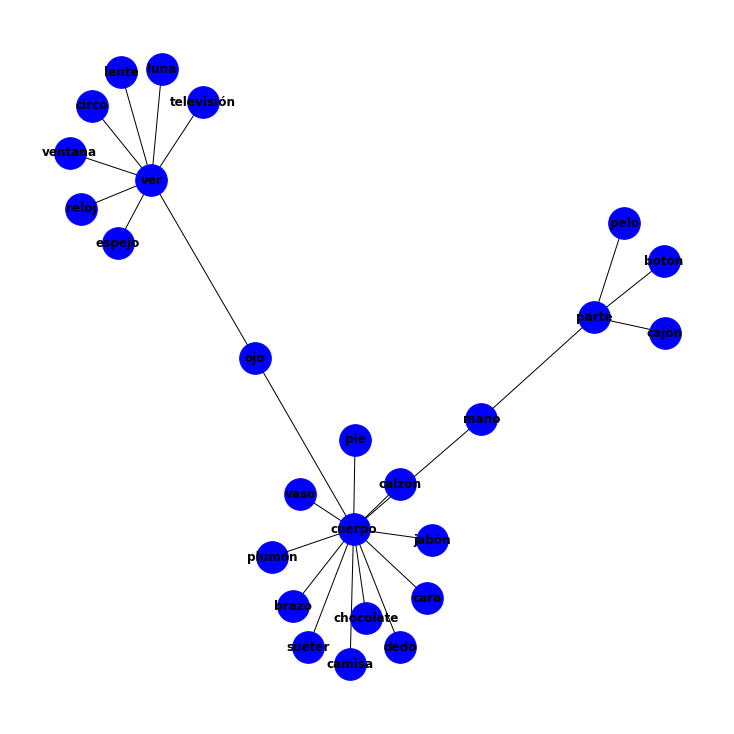

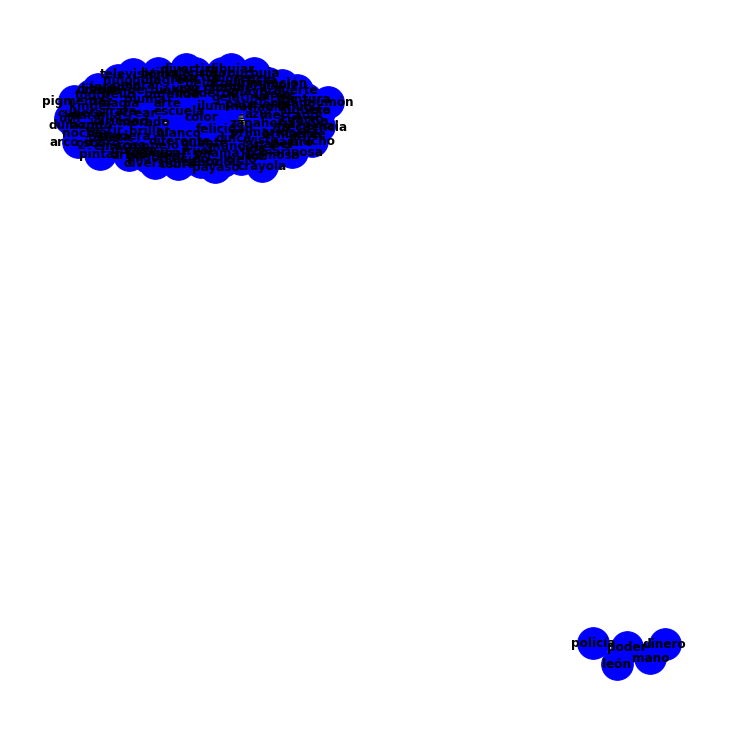

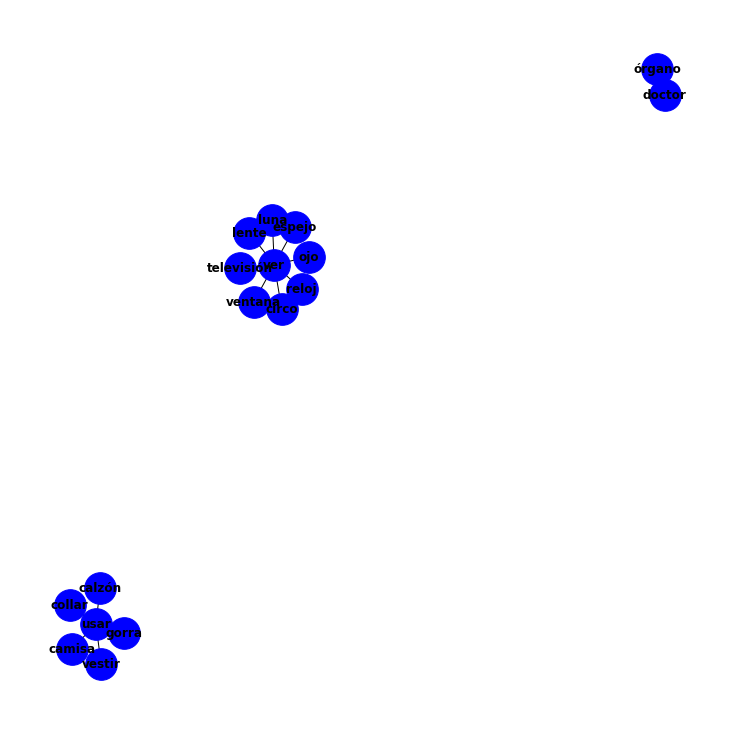

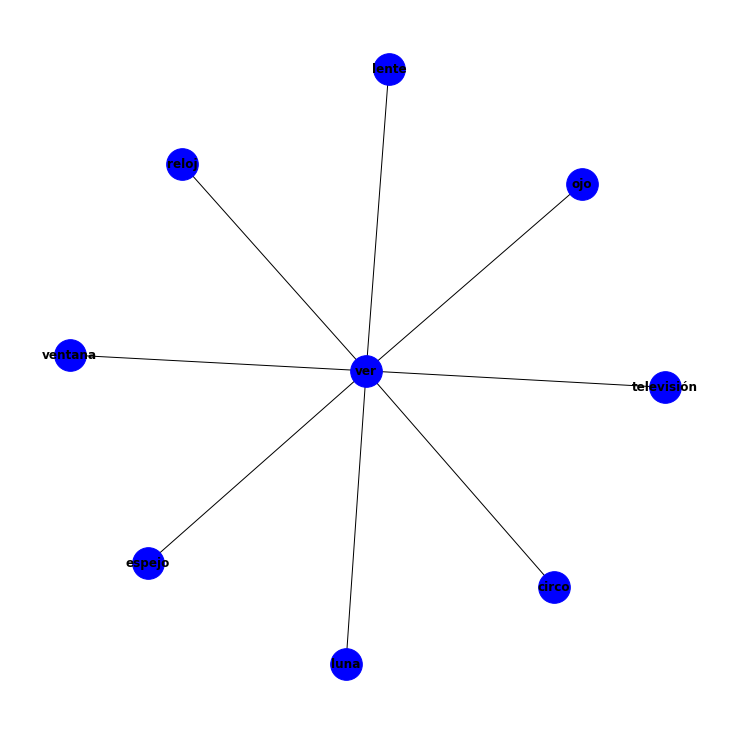

In [16]:
grafo = ConstruyeGrafos()
lista = palabras_por_definicion('ojo')
for i in range(len(lista)):
    subgrafo = crear_subgrafo(grafo[2], lista[i].split())
    dibuja_grafo(subgrafo)

In [30]:
rendimiento_mdbl_btc()

Asociacion
p@1: 0.31521739130434784 p@3: 0.5 p@5 0.5217391304347826
Frecuencia
p@1: 0.3079710144927536 p@3: 0.4891304347826087 p@5 0.532608695652174
Tiempo
p@1: 0.18115942028985507 p@3: 0.35507246376811596 p@5 0.40942028985507245


In [ ]:
rendimiento_mdbl_cbtc()